In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [2]:
def get_df(X, train=True):
    # select numeric columns and fill NA values
    numeric_columns = X.select_dtypes(include=['number']).columns
    X[numeric_columns] = X[numeric_columns].fillna(method="ffill")

    ids, Y = X["Id"], []
    if train:
        Y = X["SalePrice"]
        X = X.drop(["Id", "SalePrice"], axis=1)
    else:
        X = X.drop(["Id"], axis=1)

    # label encode categorical data
    to_encode = []
    for c in X.columns:
        if X[c].dtype == 'object':
            to_encode.append(c)

    label_encode = X[to_encode].apply(LabelEncoder().fit_transform)
    X = pd.concat([X, label_encode], axis=1)

    # drop encoded columns
    X = X.drop(label_encode, axis=1)

    return X, Y, ids


In [3]:

# read train data
data = pd.read_csv("data/train.csv")


<AxesSubplot:>

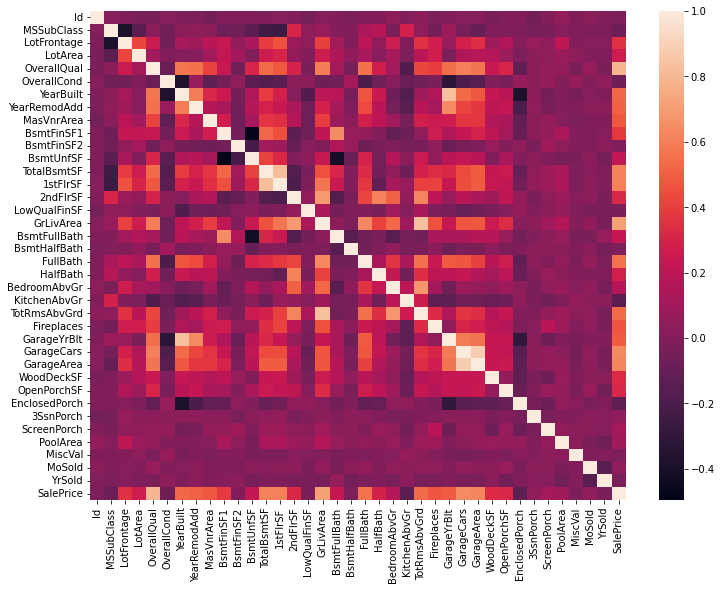

In [4]:
# vizualize feature correlation
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data.corr())

In [5]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()
           ).sort_values(ascending=True)
missing_data = pd.concat([total, percent], axis=1,
                         keys=['Total', 'Percent'])

print(missing_data)

# delete columns where more then 50% of the values are null
del_list = [col for col in missing_data.T.columns if missing_data.Percent[col] > 0.5]
print('delete:', del_list)
data = data.drop(columns=del_list)


             Total   Percent
PoolQC        1453  0.995205
MiscFeature   1406  0.963014
Alley         1369  0.937671
Fence         1179  0.807534
FireplaceQu    690  0.472603
...            ...       ...
ExterQual        0  0.000000
Exterior2nd      0  0.000000
Exterior1st      0  0.000000
RoofMatl         0  0.000000
SalePrice        0  0.000000

[81 rows x 2 columns]
delete: ['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [6]:
# outliers
data = pd.read_csv("data/train.csv")
numeric_cols = data.select_dtypes(include=['number']).columns
numeric_df = data[numeric_cols].fillna(method="ffill")

# filter rows that contain a value that is more than 3 std. deviations away from its column mean
filter_mask = (np.abs(stats.zscore(numeric_df)) < 3).all(axis=1)
print("delete %d rows that containe outliers" % (data.shape[0] - filter_mask.sum()))
data = data[filter_mask]


delete 444 rows that containe outliers


In [7]:
# process data into dataframe used for training
X, y, _ = get_df(data)

In [8]:
model = xgb.XGBRegressor()

# do grid search and cross validation
xgb_hyperparams = {'n_estimators': [100, 150],
                   'learning_rate': [0.01, 0.1],
                   'max_depth': [3, 4]}

opt_model = GridSearchCV(model, xgb_hyperparams, n_jobs=4,
                   cv=StratifiedKFold(n_splits=4, shuffle=True),
                   scoring='neg_mean_squared_log_error')

opt_model.fit(X, y)

# print evaluation
print(opt_model.best_score_)
print(opt_model.best_params_)


/home/josef/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


-0.015952982689715317
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


In [9]:
# predicting test set and create submission file
with open("submission.txt", 'w') as outfile:
    outfile.write("Id,SalePrice\n")

    data = pd.read_csv("data/test.csv")
    X_test, _, ids = get_df(data, train=False)

    preds = opt_model.predict(X_test)
    for pred, id in zip(preds, ids):
        outfile.write(str(id) + ',' + str(pred) + '\n')
